# Task 2

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np 
from scipy.io import loadmat
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,roc_auc_score, confusion_matrix
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from keras.preprocessing.image import ImageDataGenerator
import random
from sklearn.metrics import plot_confusion_matrix

In [2]:
np.random.seed(31415)

### Helper Functions

In [3]:
def scree_plot(n_comp):
    n_comp = 20
    pca = PCA(n_components=n_comp)
    pc = pca.fit_transform(data)
    scree_df = pd.DataFrame({'exp_var':pca.explained_variance_ratio_,
                 'PC':[i for i in range(1,n_comp+1)]})
    colors = [n_comp * ['blue'] + (20-n_comp) * ['red'] ]
    scree_df['colors'] = colors[0]
    sns.barplot(x='PC',y="exp_var", 
               data=scree_df, color="c");
    plt.tight_layout()
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Varaince')

def pcplot2d():
    pca = PCA(n_components=2)
    pc = pca.fit_transform(data)
    pc_df = pd.DataFrame(data= pc, columns = ['PC1','PC2'])
    
    pc_df['class'] =labels
    sns.lmplot( x="PC1", y="PC2",
      data=pc_df, 
      fit_reg=False, 
        hue='class', 
      legend=True,
      scatter_kws={"s": 80}) 
    
def pcplot3d():
    pca = PCA(n_components=3)
    pc = pca.fit_transform(data)
    pc_df = pd.DataFrame(data= pc, columns = ['PC1','PC2','PC3'])

    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(pc_df['PC1'], pc_df['PC2'], pc_df['PC3'], c=labels,depthshade=False)
    
def training_plot(model):
    results = pd.DataFrame(model.cv_results_)
    x = results['param_pca__n_components']
    y = results['mean_test_score']

    best_x = results[results['rank_test_score']==1]['param_pca__n_components']
    best_y = results[results['rank_test_score']==1]['mean_test_score']

    plt.figure(figsize=(6,4),dpi=100)
    sns.lineplot(x,y)
    plt.scatter(best_x,best_y,c='red',label='Highest Accuracy')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Mean Accuracy Score')
    # plt.title('Bayes Models: Number of Principal Components')
    plt.legend(loc=(.6,0.08))

def training_time_plot(model):
    results = pd.DataFrame(model.cv_results_)
    x = results['param_pca__n_components']
    y = results['mean_fit_time']

    best_x = results[results['rank_test_score']==1]['param_pca__n_components']
    best_y = results[results['rank_test_score']==1]['mean_fit_time']

    plt.figure(figsize=(6,4),dpi=100)
    sns.lineplot(x,y)
    plt.scatter(best_x,best_y,c='red',label='Highest Accuracy')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Mean Training Time')
    plt.legend(loc=(.6,0.08))

def model_eval(model, X_test, y_test):
    ypred = model.predict(X_test)
    results = {'Accuracy' : [accuracy_score(y_test, ypred)],
               'F1': [f1_score(y_test, ypred, average='micro')], 
               'Precision': [precision_score(y_test, ypred, average='micro')],
                'Recall': [recall_score(y_test, ypred, average='micro')]}
    results_df = pd.DataFrame(results)
    
    results_df = results_df.style.hide_index()
    return results_df

def confusion_matrix(model, X_test, y_test, labels_list):
    ypred = model.predict(X_test)
    mat = confusion_matrix(y_test, ypred) 
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                        xticklabels=labels_list,
                        yticklabels=labels_list)
    plt.xlabel('true label')
    plt.ylabel('predicted label');

In [4]:
#load data chunks and converts to numpy arrays
def load_data_chunks():
    raw_face = np.array(loadmat('./data/data.mat')['face'])
    raw_pose = np.array(loadmat('./data/pose.mat')['pose'])
    raw_illum = np.array(loadmat('./data/illumination.mat')['illum'])
    aug_neutral = np.load('data/aug_neutral.npy', allow_pickle=True)
    aug_smile = np.load('data/aug_smile.npy', allow_pickle=True)
    return raw_face, (raw_pose, raw_illum), (aug_neutral,aug_smile)

def make_pose_dataset(raw_pose, num_subjects, augmented=False):
    pose_dataset = []
    pose_labels = []
    if augmented == False:
        for subject in range(num_subjects):
            for pose in range(13):
                pose_dataset.append(raw_pose[0][:,:,pose,subject].reshape((48*40)))
                pose_labels.append(subject)
    else:
        for subject in range(num_subjects):
            for pose in range(13):
                pose_dataset.append(raw_pose[0][:,:,pose,subject].reshape((48*40)))
                pose_labels.append(subject)
        for subject in range(num_subjects):
            for pose in range(21):
                img = raw_pose[1][:,pose,subject].reshape((40,48))
                img = np.flip(np.rot90(img)).reshape((48*40))
                pose_dataset.append(img)
                pose_labels.append(subject)
                
    pose_dataset = np.array(pose_dataset)
    pose_labels = np.transpose(np.array(pose_labels))
    return pose_dataset, pose_labels

### load data and create dataset


In [5]:
#load data chunks
_, raw_pose, _ = load_data_chunks()

# Data Exploration

In [6]:
scree_plot(n_comp=16)
pcplot2d()
pcplot3d()

NameError: name 'data' is not defined

In [7]:
#create face dataset
data, labels = make_pose_dataset(raw_pose, num_subjects=10, augmented=False)
#split data into train and test
X_train, X_test, y_train, y_test = train_test_split(data, labels, 
                                                    test_size=0.1, random_state=42, shuffle='true', stratify=labels)
X_train = X_train/255
X_test = X_test/255
print(X_train.shape)
print(X_test.shape)

(117, 1920)
(13, 1920)


# Gaussian Bayes

In [35]:
def bayes_training():
    best_score = []
    best_params = []
    with_scaling = []
    num_sub = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65]
    trained_models = []
    
    param_grid = {
    'pca__n_components': [i for i in range(1,100)]
    }
    
    for i in range(len(num_sub)):
        data, labels = make_pose_dataset(raw_pose, num_subjects=num_sub[i], augmented=False)
        X_train, X_test, y_train, y_test = train_test_split(data, labels, 
                                                        test_size=0.15, 
                                                        random_state=42, 
                                                        shuffle='true', 
                                                        stratify=labels)
        gnb = GaussianNB()
        pca = PCA()
        
        X_train = X_train/255
        X_test = X_test/255

        pipe = Pipeline(steps=[('pca', pca), ('bayes', gnb)])
        search = GridSearchCV(pipe, param_grid, scoring='accuracy', n_jobs=-1, cv=5)
        search.fit(X_train, y_train)
        best_score.append(search.best_score_)
        best_params.append(search.best_params_)
        trained_models.append(search)

    results_og = pd.DataFrame({'Number of Subjects':num_sub, 
                               'Best Params':[i['pca__n_components'] for i in best_params], 
                               'Best Training Score': best_score})
    
    return results_og, trained_models

In [33]:
def bayes_testing(models, results, X_test, y_test):
    test_accuracy = []
    for model in models:
        ypred = model.predict(X_test)
        test_accuracy.append(accuracy_score(y_test, ypred))
    results['Testing Accuracy'] = test_accuracy
    
    return results

In [13]:
results, models = bayes_training()

In [14]:
results

,Number of Subjects,Best Params,Best Score
0,10,75,0.881522
1,15,69,0.817143
2,20,92,0.765032
3,25,81,0.753536
4,30,73,0.698028
5,35,79,0.677386
6,40,88,0.685930
7,45,96,0.703414
8,50,85,0.687179
9,55,96,0.674830


In [34]:
bayes_testing(models, results, X_test, y_test)

,Number of Subjects,Best Params,Best Score,Testing Accuracy
0,10,75,0.881522,0.846154
1,15,69,0.817143,1.000000
2,20,92,0.765032,1.000000
3,25,81,0.753536,0.923077
4,30,73,0.698028,0.923077
5,35,79,0.677386,1.000000
6,40,88,0.685930,1.000000
7,45,96,0.703414,1.000000
8,50,85,0.687179,1.000000
9,55,96,0.674830,0.923077


In [37]:
best_score = []
best_params = []
with_scaling = []
num_sub = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65]
for i in range(len(num_sub)):
    data, labels = make_pose_dataset(raw_pose, num_subjects=num_sub[i], augmented=False)
    X_train, X_test, y_train, y_test = train_test_split(data, labels, 
                                                    test_size=0.1, 
                                                    random_state=42, 
                                                    shuffle='true', 
                                                    stratify=labels)
    X_train = X_train/255
    X_test = X_test/255
    
    search = GridSearchCV(pipe, param_grid, scoring='accuracy', n_jobs=-1, cv=5)
    search.fit(X_train, y_train)
    best_score.append(search.best_score_)
    best_params.append(search.best_params_)
    
results_og = pd.DataFrame({'Number of Subjects':num_sub, 
                           'Best Params':[i['pca__n_components'] for i in best_params], 
                           'Best Score': best_score})
print(results_og)

    Number of Subjects  Best Params  Best Score
0                   10           72    0.881522
1                   15           92    0.828571
2                   20           75    0.756614
3                   25           71    0.753594
4                   30           69    0.703662
5                   35           86    0.672569
6                   40           91    0.698696
7                   45           93    0.703396
8                   50           81    0.685470
9                   55           83    0.673316
10                  60           93    0.653830
11                  65           95    0.661842


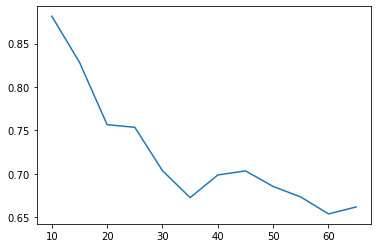

In [38]:
plt.plot(results_og['Number of Subjects'], results_og['Best Score'])

In [39]:
best_score = []
best_params = []
with_scaling = []
num_sub = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65]
for i in range(len(num_sub)):
    data, labels = make_pose_dataset(raw_pose, num_subjects=num_sub[i], augmented=True)
    X_train, X_test, y_train, y_test = train_test_split(data, labels, 
                                                    test_size=0.1, 
                                                    random_state=42, 
                                                    shuffle='true', 
                                                    stratify=labels)
    X_train = X_train/255
    X_test = X_test/255
    
    search = GridSearchCV(pipe, param_grid, scoring='accuracy', n_jobs=-1, cv=5)
    search.fit(X_train, y_train)
    best_score.append(search.best_score_)
    best_params.append(search.best_params_)
    
results_aug = pd.DataFrame({'Number of Subjects':num_sub, 
                              'Best Params':[i['pca__n_components'] for i in best_params], 
                              'Best Score': best_score})
print(results_aug)

    Number of Subjects  Best Params  Best Score
0                   10           44    0.892015
1                   15           41    0.873555
2                   20           55    0.830108
3                   25           67    0.831373
4                   30           93    0.803908
5                   35           85    0.794597
6                   40           96    0.766363
7                   45           81    0.766870
8                   50           90    0.769935
9                   55           95    0.777174
10                  60           84    0.771237
11                  65           98    0.761689


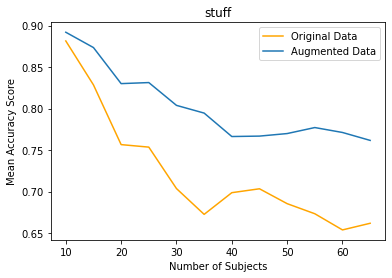

In [40]:
x1, y1, = results_og['Number of Subjects'], results_og['Best Score']
x2, y2, = results_aug['Number of Subjects'], results_aug['Best Score']
plt.plot(x1,y1,c='orange',label ='Original Data')
plt.plot(x2,y2, label='Augmented Data')
plt.xlabel('Number of Subjects')
plt.ylabel('Mean Accuracy Score')
plt.title('stuff')
plt.legend()

## Best Bayes Model

In [60]:
data, labels = make_pose_dataset(raw_pose, num_subjects=35, augmented=True)
X_train, X_test, y_train, y_test = train_test_split(data, labels, 
                                                    test_size=0.1, 
                                                    random_state=42, 
                                                    shuffle='true', 
                                                    stratify=labels)
X_train = X_train/255
X_test = X_test/255

In [61]:
pca = PCA(n_components=85)
gnb = GaussianNB()
best_pipe = Pipeline(steps=[('pca', pca), ('bayes', gnb)])

In [62]:
best_pipe.fit(X_train, y_train)

Pipeline(steps=[('pca', PCA(n_components=85)), ('bayes', GaussianNB())])

In [66]:
model_eval(best_pipe, X_test, y_test)

Accuracy,F1,Precision,Recall
0.806723,0.806723,0.806723,0.806723


In [65]:
# plot_confusion_matrix(best_pipe, X_test, y_test)

### Bayes Model Selection

In [67]:
training_plot(bayes_search)
training_time_plot(bayes_search)

NameError: name 'bayes_search' is not defined

#### testing

In [102]:
model_eval(bayes_search, X_test, y_test)

Accuracy,F1,Precision,Recall
0.823529,0.823529,0.823529,0.823529


# KNN

In [ ]:
distances = ['euclidean','manhattan','chebyshev','minkowski']

In [68]:
scaler = StandardScaler()
pca = PCA()
knn = KNeighborsClassifier()
param_grid = {
    'pca__n_components': [i for i in range(5,30,5)],
    'knn__n_neighbors' : [i for i in range(1,11)],  
    'knn__metric' : ['euclidean','manhattan','chebyshev','minkowski'],
    'knn__weights' : ['uniform','distance'],
}
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)

In [69]:
pipe = Pipeline(steps=[('pca', pca), ('knn', knn)])
knn_search = GridSearchCV(pipe, param_grid, scoring='accuracy', cv=5, n_jobs=-1)

In [71]:
best_score = []
best_params = []
with_scaling = []
num_sub = [10, 20, 30, 40, 50, 60 ]
for i in range(len(num_sub)):
    data, labels = make_pose_dataset(raw_pose, num_subjects=num_sub[i], augmented=True)
    X_train, X_test, y_train, y_test = train_test_split(data, labels, 
                                                    test_size=0.1, 
                                                    random_state=42, 
                                                    shuffle='true', 
                                                    stratify=labels)
    search = GridSearchCV(pipe, param_grid, scoring='accuracy', n_jobs=-1, cv=5)
    search.fit(X_train, y_train)
    best_score.append(search.best_score_)
    best_params.append((search.best_params_['knn_n_neighbors'],search.best_params_['pca_n_components']))
knn_results = pd.DataFrame({'Number of Subjects':num_sub, 'Best Params':best_params, 'Best Score': best_score})
knn_results

,Number of Subjects,Best Params,Best Score
0,10,"{'knn__metric': 'manhattan', 'knn__n_neighbors...",0.869170
1,20,"{'knn__metric': 'manhattan', 'knn__n_neighbors...",0.833440
2,30,"{'knn__metric': 'manhattan', 'knn__n_neighbors...",0.747280
3,40,"{'knn__metric': 'manhattan', 'knn__n_neighbors...",0.751643
4,50,"{'knn__metric': 'manhattan', 'knn__n_neighbors...",0.755556
5,60,"{'knn__metric': 'manhattan', 'knn__n_neighbors...",0.747281


In [76]:
nn =  [i['knn__n_neighbors'] for i in knn_results['Best Params']]
pc = [i['pca__n_components'] for i in knn_results['Best Params']]

In [79]:
print(pc)
print(nn)

[25, 25, 25, 25, 25, 25]
[1, 1, 1, 2, 1, 2]


In [80]:
results = pd.DataFrame(knn_search.cv_results_)
results = results[['param_knn__n_neighbors',
                   'param_pca__n_components', 'mean_test_score',
                   'mean_fit_time','mean_score_time']]
results.sort_values(by=['mean_test_score'], inplace=True, ascending=False)
results.head(5)


AttributeError: 'GridSearchCV' object has no attribute 'cv_results_'

#### testing

In [38]:
model_eval(knn_search, X_test, y_test)

Accuracy,F1,Precision,Recall
0.882353,0.882353,0.882353,0.882353
